# Listagem de artigos

**Fonte**: ASAA Journal

![ASAA Journal](img/asaa-journal-search.png)

**Bibliotecas importadas**

In [1]:
from time import sleep
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support.select import Select

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

options = Options()
options.binary_location = r'C:\Program Files (x86)\Mozilla Firefox\firefox.exe' # Localicação do programa firefox.exe

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\UFT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
plt.style.use('seaborn')

In [3]:
def captura_artigos_anpcont(palavra_chave, ano=2010):
    url = 'https://asaa.anpcont.org.br/index.php/asaa/search'
    driver = webdriver.Firefox(executable_path='../webdrivers/geckodriver.exe', options=options)
    driver.get(url)
    input_search_xp = '//*[@id="query"]'
    btn_search_xp = '/html/body/div/div[1]/div[1]/div/form/div[2]/button'
    select_year_xp = '//*[@id="dateFromYear"]'
    driver.find_element(By.XPATH, input_search_xp).send_keys(palavra_chave)
    select_element = driver.find_element(By.XPATH, select_year_xp)
    select_object = Select(select_element)
    select_object.select_by_value(str(ano))
    driver.find_element(By.XPATH, btn_search_xp).click()
    search_results = driver.find_element(By.CLASS_NAME, 'search_results')
    artigos = search_results.find_elements(By.TAG_NAME, 'li')
    list_data = lista_artigos(driver, artigos)
    col_names = ['Data', 'Título', 'Palavras-Chave', 'Resumo', 'Link', 'Qtd. Autores', 'Autor1.Nome', 'Autor1.Afiliação', 'Autor2.Nome', 'Autor2.Afiliação', 'Autor3.Nome', 'Autor3.Afiliação', 'Autor4.Nome', 'Autor4.Afiliação', 'Autor5.Nome', 'Autor5.Afiliação', 'Autor6.Nome', 'Autor6.Afiliação']
    df = pd.DataFrame(list_data, columns=col_names)
    driver.close()
    return df

In [4]:
def captura_autores(soup):
    lista_autores = []
    try:
        ul_authors = soup.find('ul', {'class': 'authors'})
        li_authors = ul_authors.find_all('li')
        qtd_autores = len(li_authors)
        for autor in li_authors:
            nome = autor.find('span', {'class': 'name'}).text.replace('\n', '').replace('\t', '')
            afiliacao = autor.find('span', {'class': 'affiliation'}).text.replace('\n', '').replace('\t', '')
            lista_autores.append(nome)
            lista_autores.append(afiliacao)
        if qtd_autores < 6:
            for i in range(6 - qtd_autores):
                lista_autores.append('')
                lista_autores.append('')
    except:
        for i in range(6):
            lista_autores.append('')
            lista_autores.append('')
    lista_autores = [qtd_autores] + lista_autores
    return lista_autores

In [5]:
def lista_artigos(driver, artigos):
    list_data = []
    for artigo in artigos:
        a = artigo.find_element(By.TAG_NAME, 'a')
        link = a.get_attribute('href')
        titulo = a.text.capitalize()
        #autores = artigo.find_element(By.CLASS_NAME, 'authors').text
        data = artigo.find_element(By.CLASS_NAME, 'published').text
        driver.execute_script("window.open('');")
        driver.switch_to.window(driver.window_handles[1])
        driver.get(link)
        sleep(2)

        html = driver.page_source
        soup = BeautifulSoup(html)
        kw = captura_keywords(soup)
        abstract = captura_abstract(soup)
        row = [data, titulo, kw, abstract, link]
        row += captura_autores(soup)
        list_data.append(row)
        driver.close()
        driver.switch_to.window(driver.window_handles[0])
    return list_data

In [6]:
def captura_keywords(soup):
    try:
        kw_section = soup.find('section', {'class': 'item keywords'})
        kw = kw_section.text.replace('Keywords:', '').replace('\n', '').replace('\t', '').replace(',', '.').lower()
    except:
        kw = ''
    return kw

In [7]:
def captura_abstract(soup):
    try:
        abstract_section = soup.find('section', {'class': 'item abstract'})
        abstract = abstract_section.text.replace('Abstract', '').replace('\n', '').replace('\t', '')
    except:
        abstract = ''
    return abstract

In [8]:
chaves_de_pesquisa = ['contabilidade ambiental', 'balanço social']

In [9]:
anpcont_df = pd.DataFrame()
for chave_de_pesquisa in chaves_de_pesquisa:
    df = captura_artigos_anpcont(chave_de_pesquisa)
    anpcont_df = pd.concat([anpcont_df, df])
anpcont_df.reset_index(inplace=True)
anpcont_df = anpcont_df.drop_duplicates(subset='Título')
anpcont_df['Data'] = pd.to_datetime(anpcont_df['Data'], format='%d/%m/%Y')
anpcont_df = anpcont_df.drop(['index'], axis=1)

C:\Users\UFT\AppData\Local\Temp\ipykernel_8184\3859316771.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path='../webdrivers/geckodriver.exe', options=options)
C:\Users\UFT\AppData\Local\Temp\ipykernel_8184\3859316771.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path='../webdrivers/geckodriver.exe', options=options)


In [10]:
anpcont_df.head()

,Data,Título,Palavras-Chave,Resumo,Link,Qtd. Autores,Autor1.Nome,Autor1.Afiliação,Autor2.Nome,Autor2.Afiliação,Autor3.Nome,Autor3.Afiliação,Autor4.Nome,Autor4.Afiliação,Autor5.Nome,Autor5.Afiliação,Autor6.Nome,Autor6.Afiliação
0,2019-11-18,"Responsabilidade ambiental, custo de capital, ...",certificação. sinalização. custo de capital. r...,O presente estudo teve por objetivo verificar ...,https://asaa.anpcont.org.br/index.php/asaa/art...,4,Jessica Prado Martins,Fucape Business School,Danilo Soares Monte-mor,Fucape Business School,Silvania Neris Nossa,Fucape Business School,Valcemiro Nossa,Fucape Business School,,,,
1,2020-08-31,Despesas de exercícios anteriores: uma análise...,despesas de exercícios anteriores. planejament...,O registro contábil de Despesas de Exercícios ...,https://asaa.anpcont.org.br/index.php/asaa/art...,2,Saulo Silva Lima Filho,Universidade Federal do Paraná,Blênio Cezar Severo Peixe,Universidade Federal do ParanáDepartamento de ...,,,,,,,,
2,2020-01-23,A certificação iso 14001 e o endividamento das...,certificação. iso 14001. endividamento. b3. co...,A certificação ISO 14001 compreende um conjunt...,https://asaa.anpcont.org.br/index.php/asaa/art...,4,Enezio Mariano da Costa,Fucape Business School,Valcemiro Nossa,Fucape Business School,Silvania Neris Nossa,Fucape Business School,Vania Maria da Costa Borgerth,Fucape Business School,,,,
3,2019-11-18,A influência da estruturação na relação entre ...,sistemas de controle gerencial. alavancas de c...,O tema da pesquisa versa sobre a estruturação ...,https://asaa.anpcont.org.br/index.php/asaa/art...,4,Ivan Rafael Defaveri,Universidade Estadual do Oeste do Paraná,Delci Grapegia Dal Vesco,Universidade Estadual do Oeste do Paraná,Carlos Alberto Diehl,Universidade Vale do Rio dos Sinos,Leandro Augusto Toigo,Universidade Estadual do Oeste do Paraná,,,,
4,2020-04-22,Custos da qualidade em hospitais acreditados,custos da qualidade. custos de controle. custo...,Esse estudo tem como objetivo identificar como...,https://asaa.anpcont.org.br/index.php/asaa/art...,4,Katia Abbas,Universidade Estadual de Maringá,Paulo Henrique Rezende da Silva,Possui graduação em Ciências Contábeis pela Un...,Marcia Maria Dos Santos Bortolocci Espejo,Universidade Federal do Mato Grosso do SUL (UFMS),Leticia Matiolli Grejo,Universidade Estadual do Paraná (UNESPAR - Apu...,,,,


In [11]:
anpcont_df['Qtd. Autores'].describe()

count    23.000000
mean      2.739130
std       1.009833
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       4.000000
Name: Qtd. Autores, dtype: float64

In [12]:
lista = []
for i in range(1, 7):
    lista += anpcont_df[f'Autor{i}.Afiliação'].to_list()
lista = [_ for _ in lista if _ != '']

afiliacao = pd.DataFrame(lista, columns=['Afiliação'])
afiliacao_count = afiliacao.value_counts()[:10].reset_index().rename(columns={0:'Count'})

In [13]:
afiliacao_count

,Afiliação,Count
0,Fucape Business School,12
1,Universidade Federal de Uberlândia,6
2,Universidade de São Paulo,5
3,FEA-RP/USP,3
4,Universidade Federal de Pernambuco,3
5,Universidade Federal do Paraná,3
6,Universidade Federal de Uberlândia - UFU,3
7,Universidade Regional de Blumenau,3
8,Universidade Estadual do Oeste do Paraná,3
9,Universidade Federal de Viçosa,2


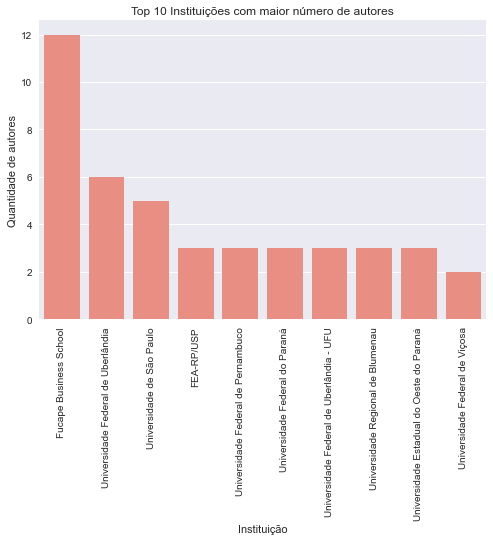

In [14]:
ax = sns.barplot(x='Afiliação', y='Count', data=afiliacao_count, color='salmon')
ax.set_xlabel('Instituição')
ax.set_ylabel('Quantidade de autores')
ax.set_title('Top 10 Instituições com maior número de autores')
plt.xticks(rotation=90)
plt.show()

In [15]:
palavras_chave = []
for item in anpcont_df['Palavras-Chave'].to_list():
    aux = item.split('.')
    palavras_chave += [_ for _ in aux if _ != '']

    
palavras_df = pd.DataFrame(palavras_chave, columns=['Palavras'])
palavras_count = palavras_df.value_counts()[:10].reset_index().rename(columns={0:'Count'})
palavras_count

,Palavras,Count
0,sistemas de controle gerencial,3
1,gerenciamento de resultados,2
2,certificação,2
3,sustentabilidade,2
4,hegemonia,2
5,governança corporativa,2
6,alavancas de controle,2
7,brasil,1
8,sistemas de controle interativo,1
9,teoria da estruturação,1


In [16]:
comment_words = ''
stopwords = set(stopwords.words('portuguese'))

In [17]:
for val in anpcont_df['Palavras-Chave']:
    val = str(val.replace('.', ''))
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()  
    comment_words += " ".join(tokens)+" "

In [18]:
wordcloud = WordCloud(width = 1000, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

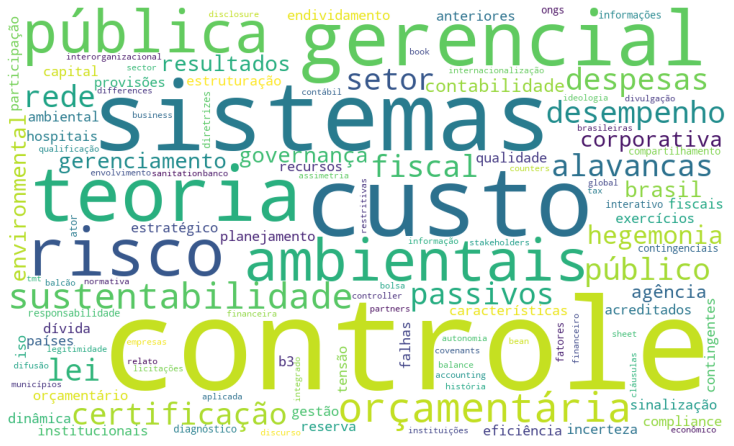

In [19]:
# plot the WordCloud image                      
plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [24]:
artigos_ano = anpcont_df['Data'].groupby([anpcont_df['Data'].dt.year]).agg('count')

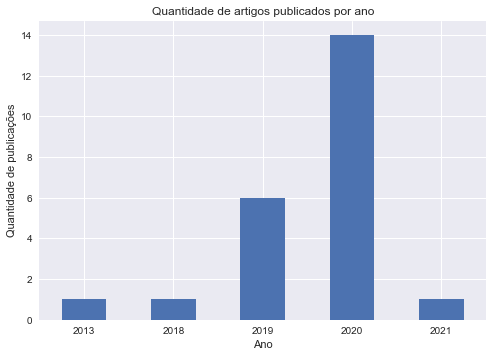

In [36]:
ax = artigos_ano.plot.bar()
ax.set_xlabel('Ano')
ax.set_ylabel('Quantidade de publicações')
ax.set_title('Quantidade de artigos publicados por ano')
plt.xticks(rotation=0)

plt.show()